# [Towards Evaluating the Robustness of Neural Networks<br />对神经网络鲁棒性的评估的研究](http://arxiv.org/abs/1608.04644)

Defensive distillation is a recently proposed approach that can take an arbitrary neural network, and increase its robustness, reducing the success rate of current attacks’ ability to find adversarial examples from 95% to 0.5%.  
防御蒸馏是最近提出的一种方法，它可以利用任意神经网络，提高其鲁棒性，将当前攻击发现对抗样本的成功率从 95% 降低到 0.5%。

In general, there are two different approaches one can take to evaluate the robustness of a neural network: attempt to prove a lower bound, or construct attacks that demonstrate an upper bound.  
一般来说，有两种不同的方法可以用来评估神经网络的鲁棒性：尝试证明下限，或构建证明上限的攻击。

In this paper we create a set of attacks that can be used to construct an upper bound on the robustness of neural networks.  
在本文中，我们创建了一组攻击，可用于构建神经网络鲁棒性的上限。

We evaluate our attacks on three standard datasets: MNIST, a digit-recognition task (0-9); CIFAR-10, a smallimage recognition task, also with 10 classes; and ImageNet, a large-image recognition task with 1000 classes.  
我们在三个标准数据集上评估了我们的攻击：MNIST，数字识别任务（0-9）；CIFAR-10，小型图像识别任务，也有 10 个类别；ImageNet，大型图像识别任务，有 1000 个类别。

This paper makes the following contributions:  
本文的贡献如下：

- We introduce three new attacks for the $L_{0}$, $L_{2}$, and $L_{∞}$ distance metrics. Our attacks are significantly more effective than previous approaches. Our $L_{0}$ attack is the first published attack that can cause targeted misclassification on the ImageNet dataset.  
我们针对 $L_{0}$、$L_{2}$ 和 $L_{∞}$ 距离度量引入了三种新的攻击。我们的攻击比以前的方法更有效。我们的 $L_{0}$ 攻击是首次发布的能在 ImageNet 数据集上造成定向误分类的攻击。
- We apply these attacks to defensive distillation and discover that distillation provides little security benefit over un-distilled networks.  
我们将这些攻击应用于防御蒸馏，发现与未蒸馏的网络相比，蒸馏的安全优势很小。
- We propose using high-confidence adversarial examples in a simple transferability test to evaluate defenses, and show this test breaks defensive distillation.  
我们建议在一个简单的可转移性测试中使用高置信度的对抗样本来评估防御，并证明该测试能打破防御蒸馏。
- We systematically evaluate the choice of the objective function for finding adversarial examples, and show that the choice can dramatically impact the efficacy of an attack.  
我们系统地评估了用于寻找对抗样本的目标函数的选择，结果表明，这种选择会极大地影响攻击的效果。

## Background<br />背景

In the space of images, which we focus on in this paper, we rely on previous work that suggests that various $L_{p}$ norms are reasonable approximations of human perceptual distance.  
在本文重点讨论的图像空间中，我们依据以往的研究成果，认为各种 $L_{p}$ 准则是人类感知距离的合理近似值。

The classifier assigns the label $C(x) = \rm{argmax}_{i} F (x)_{i}$ to the input $x$. Let $C^{∗}(x)$ be the correct label of $x$. The inputs to the softmax function are called logits.  
分类器会给输入 $x$ 分配标签 $C(x) = \rm{argmax}_{i} F (x)_{i}$，记 $C^{∗}(x)$ 为 $x$ 的正确标签。softmax 函数的输入称为 logits。

We consider three different approaches for how to choose the target class, in a targeted attack:  
在有针对性的攻击中，我们考虑了三种不同的方法来选择目标类别：

- Average Case: select the target class uniformly at random among the labels that are not the correct label.  
平均情况：从非正确标签中均匀随机地选择目标类别。
- Best Case: perform the attack against all incorrect classes, and report the target class that was least difficult to attack.  
最佳情况：对所有不正确的类别进行攻击，并报告攻击难度最小的目标类别。
- Worst Case: perform the attack against all incorrect classes, and report the target class that was most difficult to attack.  
最坏情况：对所有不正确的类别进行攻击，并报告最难攻击的目标类别。

The $L_{p}$ distance is written $‖x − x'‖_{p}$, where the $p$-norm $‖ · ‖_{p}$ is defined as  
$L_{p}$ 距离的写法是$‖x − x'‖_{p}$，其中 $p$ 范数 $‖·‖_{p}$ 的定义是
$$
||v||_{p}=(\sum_{i=1}^{n} |v_{i}|^{p})^{\frac{1}{p}}
$$

1. The $L_{0}$ distance corresponds to the number of pixels that have been altered in an image.  
$L_{0}$ 距离相当于图像中被改变的像素数。
2. $L_{2}$ distance measures the standard Euclidean distance between $x$ and $x′$.  
$L_{2}$ 距离测量 $x$ 与 $x′$ 之间的标准欧氏距离。
3. $L_{∞}$ distance measures the maximum change to any of the coordinates.  
$L_{∞}$ 距离测量坐标变化的最大值。

We believe constructing and evaluating a good distance metric is an important research question we leave to future work.  
我们认为，构建和评估一个好的距离度量是一个重要的研究问题，我们将其留待今后的工作中解决。


## Experimental setup<br />实验配置

We train two networks for the MNIST and CIFAR-10 classification tasks, and use one pre-trained network for the ImageNet classification task. We use a momentum-based SGD optimizer during training.  
我们为 MNIST 和 CIFAR-10 分类任务训练了两个网络，并为 ImageNet 分类任务使用了一个预训练网络。在训练过程中，我们使用了基于动量的 SGD 优化器。

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data

import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist_train = dset.MNIST('../1-L-BFGS/data', train=True, download=True, transform=transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_test = dset.MNIST('../1-L-BFGS/data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=2048, shuffle=False)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class MNIST(nn.Module):
    def __init__(self):
        super(MNIST, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(64*4*4, 200),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 10)
        )
    
    def forward(self, x):
        return self.net(x)

model = MNIST().to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)

In [5]:
for epoch in range(50):
    for i, (images, labels) in enumerate(train_iter):
        X=images.to(device)
        Y=labels.to(device)
        
        logits = model(X)
        cost = loss(logits, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1)%128==0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,50,i+1,len(train_iter),cost.item()))
print("Finished Training")

epoch:[1/50], iter:[128/469], loss:2.29570
epoch:[1/50], iter:[256/469], loss:1.28302
epoch:[1/50], iter:[384/469], loss:0.43286
epoch:[2/50], iter:[128/469], loss:0.11790
epoch:[2/50], iter:[256/469], loss:0.16757
epoch:[2/50], iter:[384/469], loss:0.12041
epoch:[3/50], iter:[128/469], loss:0.04923
epoch:[3/50], iter:[256/469], loss:0.08495
epoch:[3/50], iter:[384/469], loss:0.10544
epoch:[4/50], iter:[128/469], loss:0.09330
epoch:[4/50], iter:[256/469], loss:0.16689
epoch:[4/50], iter:[384/469], loss:0.17968
epoch:[5/50], iter:[128/469], loss:0.08741
epoch:[5/50], iter:[256/469], loss:0.02755
epoch:[5/50], iter:[384/469], loss:0.03765
epoch:[6/50], iter:[128/469], loss:0.04090
epoch:[6/50], iter:[256/469], loss:0.08595
epoch:[6/50], iter:[384/469], loss:0.01778
epoch:[7/50], iter:[128/469], loss:0.01563
epoch:[7/50], iter:[256/469], loss:0.02365
epoch:[7/50], iter:[384/469], loss:0.03974
epoch:[8/50], iter:[128/469], loss:0.05251
epoch:[8/50], iter:[256/469], loss:0.02509
epoch:[8/50

In [6]:
model.eval()

total = 0
correct = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)
    _, predicted = torch.max(logits.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 99.320000 %


## Our approach<br />我们的方法

We formally define the problem of finding an adversarial instance for an image $x$ as follows:  
我们为图像 $x$ 寻找对抗样本的问题正式定义如下：

$$
\min \mathfrak{D}(x,x+\delta) \\ \rm{s.t.}\ C(x+\delta)=t ,\  x+\delta \in [0,1]^{n}
$$

The above formulation is difficult for existing algorithms to solve directly, as the constraint $C(x + δ) = t$ is highly non-linear.  
由于约束条件 $C(x + δ) = t$ 是高度非线性的，现有算法很难直接求解上述公式。

We define an objective function $f$ such that $C(x + δ) = t$ if and only if $f (x + δ) ≤ 0$. There are many possible choices for $f$ :  
我们定义一个目标函数 $f$，当且仅当 $f (x + δ) ≤ 0$ 时，$C(x + δ) = t$： 

$$  
\begin{align*}
f_{1}(x′) &= −loss_{F,t}(x′) + 1 \\ 
f_{2}(x′) &= (\max_{i\not=t} (F (x′)_{i}) − F (x′)_{t})^{+} \\ 
f_{3}(x′) &= \rm{softplus}(\max_{i\not=t} (F (x′)_{i}) − F (x′)_{t}) − log(2) \\ 
f_{4}(x′) &= (0.5 − F (x′)_{t})^{+} \\
f_{5}(x′) &= − log(2F (x′)_{t} − 2) \\ 
f_{6}(x′) &= (\max_{i\not=t} (Z (x′)_{i}) − Z (x′)_{t})^{+} \\ 
f_{7}(x′) &= \rm{softplus}(\max_{i\not=t} (Z (x′)_{i}) − Z (x′)_{t}) − log(2) \\ 
\end{align*}
$$

where $s$ is the correct classification, $(e)^{+}$ is short-hand for $max(e, 0)$, $\rm{softplus}(x) = log(1 + exp(x))$, and $loss_{F,s}(x)$ is the cross entropy loss for $x$.  
其中，$s$ 是正确分类，$(e)^{+}$ 是 $max(e,0)$的简称，$\rm{softplus}(x) = log(1 + exp(x))$，$loss_{F,s}(x)$ 是 $x$ 的交叉熵损失。

Now, we formulate the problem as  
现在，我们将问题描述为

$$
\min \ \mathfrak{D}(x,x+\delta)+c·f(x+\delta) \\ \rm{s.t.}\ x+\delta \in [0,1]^{n}
$$

where $c > 0$ is a suitably chosen constant.  
其中 $c > 0$ 是一个经过适当选择的常数。

After instantiating the distance metric $\mathfrak{D}$ with an $l_p$ norm, $\mathfrak{D}(x,x+\delta) = ‖δ‖_{p}$.  
用 $l_{p}$ 准则实例化距离度量 $\mathfrak{D}$ 之后，$\mathfrak{D}(x,x+\delta) = ‖δ‖_{p}$。

We found $f_{6}$ formulation most effective.  
我们发现 $f_{6}$ 最为有效。

In our implementations we use modified binary search to choose $c$.  
在实施过程中，我们使用改进的二分搜索来选择 $c$。

To ensure the modification yields a valid image, we have a constraint on $δ$: we must have $0 ≤ x_{i} + δ_{i} ≤ 1$ for all $i$. In the optimization literature, this is known as a “box constraint.”  
为确保修改后的图像有效，我们对 $δ$ 有一个限制条件：对于所有 $i$ ，必须有 $0 ≤ x_{i} + δ_{i} ≤ 1$。在优化问题的文献中，这被称为 "盒约束"。  

We investigate three different methods of approaching this problem.  
我们研究了解决这一问题的三种不同方法。

1. Projected gradient descent performs one step of standard gradient descent, and then clips all the coordinates to be within the box. This approach can work poorly for gradient descent approaches that have a complicated update step (for example, those with momentum): when we clip the actual $x_{i}$, we unexpectedly change the input to the next iteration of the algorithm.  
投影梯度下降法执行一步标准梯度下降，然后剪切所有坐标，使其位于框内。这种方法对于更新步骤复杂的梯度下降算法（例如具有动量的梯度下降算法）可能效果不佳：当我们剪切实际 $x_{i}$ 时，会意外地改变算法下一次迭代的输入。
2. Clipped gradient descent incorporates the clipping into the objective function to be minimized. In other words, we replace $f (x + δ)$ with $f (min(max(x + δ, 0), 1))$, with the min and max taken component-wise. While solving the main issue with projected gradient descent, clipping introduces a new problem: the algorithm can get stuck in a flat spot where it has increased some component $x_{i}$ to be substantially larger than the maximum allowed. When this happens, the partial derivative becomes zero, so even if some improvement is possible by later reducing $x_{i}$, gradient descent has no way to detect this.  
剪切梯度下降法将剪切纳入要最小化的目标函数中。换句话说，我们将 $f (x + δ)$ 替换为 $f (min(max(x + δ, 0), 1))$，最小值和最大值逐元素作用。虽然解决了投影梯度下降法的主要问题，但剪切法引入了一个新问题：算法可能会卡在一个平坦点上，即某个分量 $x_{i}$ 的增大大大超过了允许的最大值。当这种情况发生时，偏导数就会变为零，因此，即使以后可以通过减少 $x_{i}$ 来改进算法，梯度下降算法也无法检测到这一点。
3. Change of variables introduces a new variable $w$ and instead of optimizing over the variable $δ$ defined above, we apply a change-of-variables and optimize over $w$, setting  
换元法引入了一个新变量 $w$，我们不再对上文定义的变量 $δ$ 进行优化，而是应用换元法，对 $w$ 进行优化，转换公式为

$$
δ_{i} = \frac{1}{2} (tanh(w_{i}) + 1) − x_{i}
$$

Since $−1 ≤ tanh(w_{i}) ≤ 1$, it follows that $0 ≤ x_{i} + δ_{i} ≤ 1$, so the solution will automatically be valid. We can think of this approach as a smoothing of clipped gradient descent that eliminates the problem of getting stuck in extreme regions.  
由于 $-1 ≤ tanh(w_{i}) ≤ 1$，因此得出 $0 ≤ x_{i}+ δ_{i} ≤ 1$，因此解就会自动成立。我们可以把这种方法看作是剪切梯度下降法的平滑化，它消除了卡在极端区域的问题。

We use the Adam optimizer almost exclusively, as we have found it to be the most effective at quickly finding adversarial examples.  
我们几乎只使用 Adam 优化器，因为我们发现它在快速查找对抗性示例方面最为有效。

We model pixel intensities as a (continuous) real number in the range $[0, 1]$. However, in a valid image, each pixel intensity must be a (discrete) integer in the range $\{0, 1, . . . , 255\}$. This additional requirement is not captured in our formulation. In practice, we ignore the integrality constraints, solve the continuous optimization problem, and then round to the nearest integer: the intensity of the $i-th$ pixel becomes $\lfloor 255(x_{i} + δ_{i}) \rceil$. This rounding will slightly degrade the quality of the adversarial example. If we need to restore the attack quality, we perform greedy search on the lattice defined by the discrete solutions by changing one pixel value at a time. This greedy search never failed for any of our attacks.  
我们将像素强度建模为范围为 $[0, 1]$ 的（连续）实数。然而，在有效图像中，每个像素强度必须是范围 $\{0, 1, ., 255\}$.我们的表述没有考虑这一额外要求。在实践中，我们忽略了整数约束，求解连续优化问题，然后四舍五入到最接近的整数：第 $i-th$ 像素的强度变为 $\lfloor 255(x_{i} + δ_{i}) \rceil$。这种四舍五入会略微降低对抗示例的质量。如果需要恢复攻击质量，我们可以在离散解定义的网格上进行贪婪搜索，每次改变一个像素值。这种贪婪搜索从未在我们的任何攻击中失败过。

### $L_{2}$ Attack<br />$L_{2}$攻击

Given $x$, we choose a target class $t$ (such that we have $t \not= C^{∗}(x)$) and then search for $w$ that solves  
给定 $x$，我们选择一个目标类 $t$（满足 $t \not= C^{∗}(x)$），然后搜索 $w$ 的解满足

$$
\min ‖ \frac{1}{2} (tanh(w) + 1) − x‖_{2}^{2} + c · f( \frac{1}{2} (tanh(w) + 1) )
$$

with $f$ defined as  
其中$f$定义为

$$
f (x′) = \max (\max\{Z(x′)_{i} : i \not= t\} − Z(x′)_{t}, −κ).
$$

The parameter $κ$ encourages the solver to find an adversarial instance $x′$ that will be classified as class $t$ with high confidence.  
参数 $κ$ 鼓励求解器找到一个高置信度归类为 $t$ 类别的对抗样本 $x′$。

Multiple starting-point gradient descent. We pick multiple random starting points close to the original image and run gradient descent from each of those points for a fixed number of iterations. We randomly sample points uniformly from the ball of radius $r$, where $r$ is the closest adversarial example found so far.  
多起点梯度下降。我们在原始图像附近随机选取多个起点，然后从每个起点开始梯度下降，迭代次数固定。我们从半径为 $r$ 的球中均匀地随机采样点，其中 $r$ 是迄今为止发现的最接近的对抗实例。

### $L_{0}$ Attack<br />$L_{0}$攻击

On each iteration, we call the $L_{2}$ adversary, restricted to only modify the pixels in the allowed set. Let $δ$ be the solution returned from the $L_{2}$ adversary on input image $x$, so that $x + δ$ is an adversarial example. We compute $g = ∇f (x + δ)$ (the gradient of the objective function, evaluated at the adversarial instance). We then select the pixel $i = \rm{arg min}_{i} g_{i} · δ_{i}$ and fix $i$, i.e., remove $i$ from the allowed set.The intuition is that $g_{i} ·δ_{i}$ tells us how much reduction to $f (·)$ we obtain from the $i$-th pixel of the image, when moving from $x$ to $x + δ$: $g_{i}$ tells us how much reduction in $f$ we obtain, per unit change to the $i$-th pixel, and we multiply this by how much the $i$-th pixel has changed. This process repeats until the $L_{2}$ adversary fails to find an adversarial example.  
在每次迭代中，我们都会调用 $L_{2}$ 对手，限制其只能修改允许集合中的像素。让$δ$成为$L_{2}$对抗者在输入图像$x$上返回的解，这样$x + δ$就是一个对抗样本。我们计算 $g = ∇f (x + δ)$ （目标函数的梯度，在对抗样本处评估）。然后，我们选择像素 $i = \rm{arg min}_{i} g_{i}· δ_{i}$ 并固定 $i$，即从允许集合中删除 $i$。直观地说，$g_{i} ·δ_{i}$告诉我们，当从 $x$ 移动到 $x + δ$ 时，我们从图像的 $i$ 像素中得到的 $f (·)$ 减少了多少：$g_{i}$告诉我们，每改变 $i$ 像素一个单位，我们得到的 $f $ 减少了多少，我们将其乘以 $i$ 像素的变化量。这个过程不断重复，直到 $L_{2}$ 对手无法找到对抗示例为止。

There is one final detail required to achieve strong results: choosing a constant $c$ to use for the $L_{2}$ adversary. To do this, we initially set $c$ to a very low value (e.g., $10^{−4}$). We then run our $L_{2}$ adversary at this $c$-value. If it fails, we double $c$ and try again, until it is successful. We abort the search if $c$ exceeds a fixed threshold (e.g., $10^{10}$).  
要获得强大的结果，还需要最后一个细节：为 $L_{2}$ 对手选择一个常数 $c$。为此，我们首先将 $c$ 设为一个非常低的值（例如 $10^{-4}$）。然后，我们在这个 $c$ 值下运行 $L_{2}$ 对抗程序。如果失败，我们就将 $c$ 加倍，然后再试一次，直到成功为止。如果 $c$ 超过固定阈值（例如 $10^{10}$），我们就会放弃搜索。



### $L_{∞}$ Attack<br />$L_{∞}$攻击

We resolve this issue using an iterative attack. We replace the $L_{2}$ term in the objective function with a penalty for any terms that exceed $τ$ (initially 1, decreasing in each iteration). This prevents oscillation, as this loss term penalizes all large values simultaneously. Specifically, in each iteration we solve  
我们使用迭代攻击来解决这个问题。我们将目标函数中的 $L_{2}$ 项替换为对任何超过 $τ$ 项的惩罚（最初为 1，每次迭代都会递减）。这样可以防止振荡，因为损失项会同时惩罚所有大值。具体来说，在每次迭代中，我们求解  

$$
\min c·f(x+\delta)+\sum_{i} [(\delta_{i}-τ)^{+}]
$$

After each iteration, if $δ_{i} < τ$ for all $i$, we reduce $τ$ by a factor of $0.9$ and repeat; otherwise, we terminate the search.  
每次迭代后，如果对所有的$i$有 $δ_{i}< τ$，我们就把 $τ$ 减少 0.9，然后重复；否则，我们就终止搜索。

Again we must choose a good constant $c$ to use for the $L_{∞}$ adversary. We take the same approach as we do for the $L_{0}$ attack.  
同样，我们必须为 $L_{∞}$ 对手选择一个合适的常数 $c$。我们采用与 $L_{0}$ 攻击相同的方法。

Using “warm-start” for gradient descent in each iteration, this algorithm is about as fast as our $L_{2}$ algorithm (with a single starting point).  
在每次迭代中使用 "热启动 "进行梯度下降，该算法的速度与我们的 $L_{2}$算法（使用单一起点）差不多。

### ATTACK EVALUATION<br />攻击评估

We report success if the attack produced an adversarial example with the correct target label, no matter how much change was required. Failure indicates the case where the attack was entirely unable to succeed.  
如果攻击生成的对抗样本具有正确的目标标签，无论需要做多大的改动，我们都会报告攻击成功。失败则表示攻击完全无法成功。

We evaluate on the first 1, 000 images in the test set on CIFAR and MNSIT. On ImageNet, we report on 1, 000 images that were initially classified correctly by Inception v3. On ImageNet we approximate the best-case and worst-case results by choosing 100 target classes (10%) at random.  
我们对 CIFAR 和 MNSIT 测试集中的前 1000 张图像进行了评估。在 ImageNet 上，我们对 Inception v3 最初正确分类的 1000 幅图像进行了报告。在 ImageNet 上，我们通过随机选择 100 个目标类别（10%）来估算最佳和最差情况下的结果。


In [7]:
def cw_l2(model, images, labels, targeted=False, c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01) :
    images = images.to(device)
    labels = labels.to(device)

    def f(x):
        outputs = model(x)
        one_hot_labels = torch.eye(len(outputs[0]))[labels].to(device)

        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.byte().bool())
        
        if targeted :
            return torch.clamp(i-j, min=-kappa)
        
        else :
            # if untargeted, optimize for making this class least likely.
            # 基本上不优化Accacuray的loss
            return torch.clamp(j-i, min=-kappa)
    
    w = torch.zeros_like(images, requires_grad=True).to(device)

    optimizer = torch.optim.Adam([w], lr=learning_rate)

    prev = 1e10

    for step in range(max_iter) :

        a = 1/2*(nn.Tanh()(w) + 1)

        loss1 = nn.MSELoss(reduction='sum')(a, images)
        loss2 = torch.sum(c*f(a))

        cost = loss1 + loss2

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if step % (max_iter//10) == 0 :
            if cost > prev :
                print('Attack Stopped due to CONVERGENCE....')
                return a
            prev = cost
        
        print('- Learning Progress : %2.2f %%        ' %((step+1)/max_iter*100), end='\r')

    attack_images = 1/2*(nn.Tanh()(w) + 1)

    return attack_images

In [8]:
def imshow(img):
    image = img.cpu().clone().numpy()
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.show()

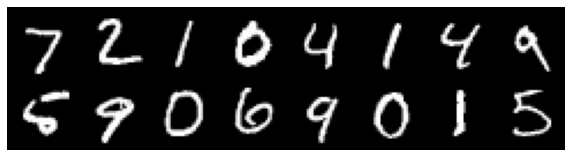

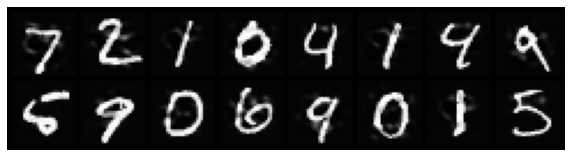

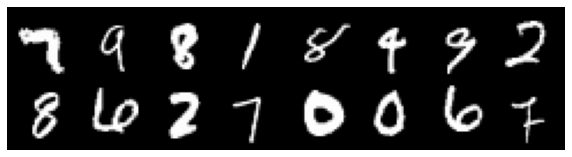

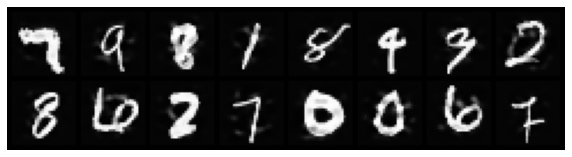

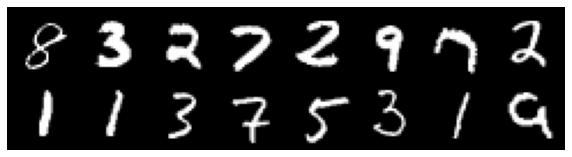

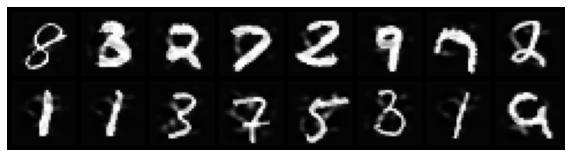

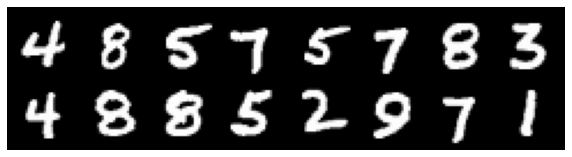

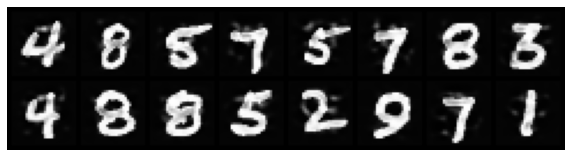

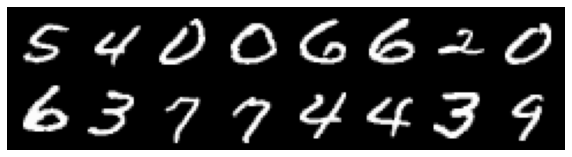

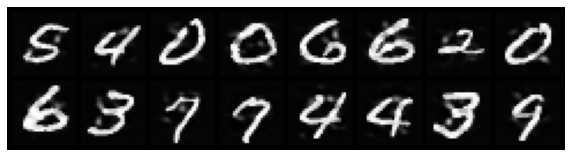

Accuracy of test text: 14.470000 %


In [9]:
correct = 0
total = 0

for images, labels in test_loader:

    images = images.to(device)
    labels = labels.to(device)

    adv_images = cw_l2(model, images, labels, targeted=False, c=1)
    adv_images = adv_images.to(device)

    outputs = model(adv_images)
    _, pre = torch.max(outputs.data, 1)

    imshow(torchvision.utils.make_grid(images[:16].cpu().data, normalize=True))
    imshow(torchvision.utils.make_grid(adv_images[:16].cpu().data, normalize=True))

    total += len(images)
    correct += (pre == labels).sum()

print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

### EVALUATING DEFENSIVE DISTILLATION<br />评估防御蒸馏

Defensive distillation uses distillation in order to increase the robustness of a neural network, but with two significant changes. First, both the teacher model and the distilled model are identical in size — defensive distillation does not result in smaller models. Second, and more importantly, defensive distillation uses a large distillation temperature to force the distilled model to become more confident in its predictions.  
防御蒸馏使用蒸馏是为了增加神经网络的鲁棒性，但有两个显著的变化。首先，教师模型和蒸馏模型大小相同，即防御蒸馏不会导致模型变小。其次，更重要的是，防御蒸馏使用较大的蒸馏温度，以迫使蒸馏模型对其预测变得更加自信。

Defensive distillation modifies the softmax function to also include a temperature constant $T$ :  
防御蒸馏将softmax函数修改为还包括一个温度常数$T$：

$$
softmax(x, T )_{i} = \frac{e^{x_{i}/T}}{\sum_{j}e^{x_{j}/T}}
$$

Intuitively, increasing the temperature causes a “softer” maximum, and decreasing it causes a “harder” maximum. As the limit of the temperature goes to 0, softmax approaches max; as the limit goes to infinity, softmax(x) approaches a uniform distribution.  
直观上，升高温度会导致一个"较软"的最大值，而降低温度则会导致一个"较硬"的最大值。当温度极限趋近于0时，softmax趋近于最大值；当极限趋于无穷大时，softmax (x)趋于均匀分布.

Defensive distillation proceeds in four steps:  
防御蒸馏分为四个步骤：
1. Train a network, the teacher network, by setting the temperature of the softmax to T during the training phase.  
在训练阶段，将 softmax 的温度设置为 T，训练一个网络，即教师网络。
2. Compute soft labels by apply the teacher network to each instance in the training set, again evaluating the softmax at temperature T .  
将教师网络应用于训练集中的每个样本，再次评估温度 T 时的 softmax，从而计算软标签。
3. Train the distilled network (a network with the same shape as the teacher network) on the soft labels, using softmax at temperature T .  
在温度 T 下，使用 softmax 在软标签上训练蒸馏网络（与教师网络形状相同的网络）。
4. Finally, when running the distilled network at test time (to classify new inputs), use temperature 1.  
最后，在测试时运行蒸馏网络（对新输入进行分类）时，使用温度 1。

L-BFGS and Deepfool fail due to the fact that the gradient of $F (·)$ is zero almost always, which prohibits the use of the standard objective function.  
L-BFGS 和 Deepfool 失败的原因在于 $F (·)$ 的梯度几乎总是为零，因此无法使用标准目标函数。

Fast Gradient Sign fails at first for the same reason LBFGS fails: the gradients are almost always zero. However, something interesting happens if we attempt the same division trick and divide the logits by T before feeding them to the softmax function: distillation still remains effective. We are unable to explain this phenomenon.  
快速梯度符号起初失败的原因与 LBFGS 失败的原因相同：梯度几乎总是为零。然而，如果我们尝试同样的除法技巧，在将 logits 输入 softmax 函数之前先将其除以 T，就会出现有趣的现象：蒸馏仍然有效。我们无法解释这一现象。

Increasing the distillation temperature does not increase the robustness of the neural network, it only causes existing attacks to fail more often.  
提高蒸馏温度并不能增强神经网络的鲁棒性，只会使现有的攻击更频繁地失败。

We accomplish this by finding high-confidence adversarial examples, which we define as adversarial examples that are strongly misclassified by the original model.  
我们通过寻找高置信度的对抗样本来实现这一目标，我们将其定义为被原始模型强烈误分类的对抗样本。

The stronger the classification on the first model, the more likely it will transfer.  
第一个模型的分类能力越强，就越有可能转移。

